<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"

for i in range(1,8):
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.z0{i}  && echo "PART {i} of 7 OK" || "ERROR downloading PART {i}"

print('MERGING PARTS')
!zip -FF curated_imgs_multipart.zip --out curated_imgs.zip > /dev/null && rm curated_imgs_multipart.z* && echo "COMPLETE" || "FAILED"

!unzip -q -o curated_imgs.zip && echo "UNZIPPED" || "FAIL"

HEAD dowloaded
PART 1 of 7 OK
PART 2 of 7 OK
PART 3 of 7 OK
PART 4 of 7 OK
PART 5 of 7 OK
PART 6 of 7 OK
PART 7 of 7 OK
MERGING PARTS
COMPLETE
UNZIPPED


In [70]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from tqdm.auto import tqdm
from PIL import Image
import pickle


n_neighbors = 10
n_components = 138
n_bootstrap_samples = 20000


df = pd.read_parquet('curated_dataset.parquet')
bootstrapped_df = df.sample(n=n_bootstrap_samples)
X = np.zeros((len(bootstrapped_df), 120, 120))

print('LOAD IMAGES')
paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
with tqdm(total=len(paths)) as progress:
  for idx, file_path in enumerate(paths):
    with Image.open(file_path) as img:
      X[idx,:,:] = np.array(img)
      progress.update()

print('CALCULATE LLE')
X_flattened = X.reshape(X.shape[0], -1)
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
X_embedded = lle.fit_transform(X_flattened)


out_file = f'unsupervised_LLE_{n_components}_neighbours_{n_neighbors}.pkl'.replace(' ', '_')
print('SAVING to: ', out_file)
with open(out_file, 'wb') as f:
  pickle.dump({'X_embedded': X_embedded,
               'metadata': bootstrapped_df}, f)
print('COMPLETE')

LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

CALCULATE LLE
SAVING to:  unsupervised_LLE_138_neighbours_20.pkl
COMPLETE


In [2]:
!pip install git+https://github.com/jqmviegas/jqm_cvi.git

  Cloning https://github.com/jqmviegas/jqm_cvi.git to /tmp/pip-req-build-xkerpj8f
  Running command git clone --filter=blob:none --quiet https://github.com/jqmviegas/jqm_cvi.git /tmp/pip-req-build-xkerpj8f
  Resolved https://github.com/jqmviegas/jqm_cvi.git to commit 9e1137d4f4df70c1287011e1a544b0c3fe36af36
  Preparing metadata (setup.py) ... done
  Created wheel for jqmcvi: filename=jqmcvi-1.0-cp311-cp311-linux_x86_64.whl size=450009 sha256=607d1fa73435c3f865ff1db13eb2edb4e924eec75bacc866c25186b3dc104921
  Stored in directory: /tmp/pip-ephem-wheel-cache-1irn43f5/wheels/29/10/d5/511cfe31e24f6431d3c2b84287074fe8d1c92c2128f93bdc9c
Successfully built jqmcvi


  0%|          | 0/1000 [00:00<?, ?it/s]

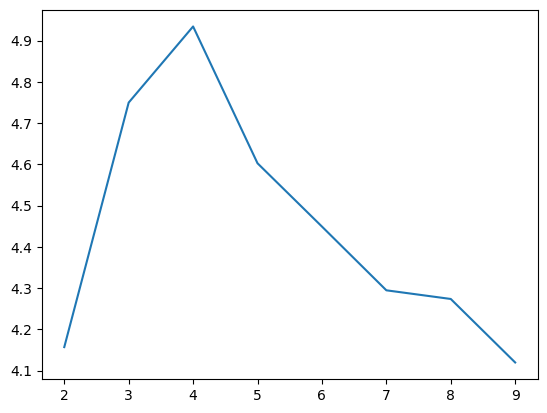

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from jqmcvi import base
import pickle
import numpy as np
from tqdm.auto import tqdm


load_from = 'unsupervised_LLE_138_neighbours_10.pkl'
sample_size = 5000
n_iterations = 1000


def get_scores(X_embedded, davis_bolduin=True, dunn=True):
  db_scores = []
  dunn_scores = []
  for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(X_embedded)
    if davis_bolduin:
      db_index = davies_bouldin_score(X_embedded, labels)
      db_scores.append(db_index)
    if dunn:
      points_by_cluster = [X_embedded[labels == c] for c in range(n_clusters)]
      dunn_index = base.dunn(points_by_cluster)
      dunn_scores.append(dunn_index)
  if davis_bolduin and not dunn:
    return db_scores
  if dunn and not davis_bolduin:
    return dunn_scores
  return db_scores, dunn_scores


with open(load_from, 'rb') as f:
  data = pickle.load(f)
  X_embedded = data['X_embedded']
  meta = data['metadata']


all_scores = []
with tqdm(total=n_iterations) as progress:
  for iter in range(n_iterations):
    row_indices = np.random.choice(X_embedded.shape[0], size=sample_size, replace=False)
    sample = X_embedded[row_indices]
    all_scores.append(get_scores(sample, dunn=False)) # dunn 1.5 min per iteration on 1000
    progress.update()
  all_scores = np.array(all_scores)

scores = np.mean(all_scores, axis=0)

import matplotlib.pyplot as plt

plt.plot(range(2, 10), scores)